# DarkELF multiphonon notebook

This notebook is meant to illustrate the part of the darkELF package for calculating dark matter-phonon rates in the multiphonon regime.

written by Ethan, updated 03/07/2021

In [1]:
%matplotlib inline

import sys, os
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
import matplotlib.ticker
from matplotlib import rc, rcParams
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
import pandas
from scipy import interpolate

# Make use of TeX\ufeff
rc('text',usetex=True)
# Change all fonts to 'Computer Modern'
rc('font',**{'size':14, 'family':'serif','serif':['Times New Roman']})
rc('xtick.major', size=5, pad=7)
rc('xtick', labelsize=15)
rc('ytick.major', size=5, pad=7)
rc('ytick', labelsize=15)

# this needs to point to the folder where darkelf.py is stored
work_dir = os.getcwd()
sys.path.append(work_dir+"/..")
plotdir=work_dir+"/plots/"

# load the package
from darkelf import darkelf, targets

## Load the materials

When loading the materials, the "dos_filename" flag must be set in order to calculate rates in the multiphonon regime. The "target_yaml" flag is set automatically and can be overridden. Auxiliary functions "Fn" are pre-tabulated corresponding to the given density of states files and loaded in by default. If using another density of states, one must first run the "create_Fn_omega()" function on the desired density of states.

In [3]:
targets.files('GaAs')


Available configuration files: 
	 GaAs.yaml
 
Available data for epsilon: 
	 GaAs_Zion.dat
	 GaAs_mermin.dat
	 Ga_pDOS.dat
	 As_pDOS.dat
	 GaAs_epsphonon_data10K.dat
 
Available data for phonon density of states: 
	 GaAs_DoS.dat
 
Available data for phonon partial density of states: 
 
Available data for Fn(omega) functions: 
	 As_Fn.dat
	 GaAs_Fn.dat
	 Ga_Fn.dat
 
Available data for form factors: 


If one is only interested in the multiphonon response, the electronic response specified with the "filename" flag is not used. If it is not specified, the code will produce a warning message, as seen below. There's also an optional form_factor_filename if one is interested in using a custom DM-atomic form factor. These can be ignored as long as we only care about DM-multiphonon scattering. Let's load a few materials.

In [4]:
gaas = darkelf(target='GaAs',dos_filename=["Ga_pDoS.dat","As_pDoS.dat"])
si = darkelf(target='Si',dos_filename="Si_DoS.dat")


 .... Loading files for GaAs
Warning! Epsilon grid in electron regime does not exist.
Warning! eps for phonon frequencies not loaded. Need to set phonon_filename 
Warning! Atomic Migdal calculation not present
Loaded Ga_pDoS.dat and As_pDoS.dat for partial densities of states
Loaded Fn(omega) functions corresponding to density of states in:  Ga_pDoS.dat   As_pDoS.dat
Warning! Dark photon fd not loaded. fd_darkphoton must be list of two filenames
 .... Loading files for Si
Warning! Epsilon grid in electron regime does not exist.
Warning! eps for phonon frequencies not loaded. Need to set phonon_filename 
Loaded Si_DoS.dat for density of states
Loaded Fn(omega) functions corresponding to density of states in:  Si_DoS.dat
Warning! Dark photon fd not loaded. Need to set fd_filename if needed. Otherwise defaults to massive mediator 


# Cross section plots

Now using the sigma_nucleon function to calculate the required DM-nucleon cross-section for a rate of 3 events/kg/yr

Points 0 to 4 took 4.8724400997161865 seconds to calculate
Points 5 to 9 took 21.21748924255371 seconds to calculate
Points 10 to 14 took 35.21003293991089 seconds to calculate
Points 15 to 19 took 36.38929986953735 seconds to calculate
Points 20 to 24 took 36.71138119697571 seconds to calculate
Points 25 to 29 took 45.920639991760254 seconds to calculate
Points 30 to 34 took 43.52887415885925 seconds to calculate
Points 35 to 39 took 31.960469961166382 seconds to calculate


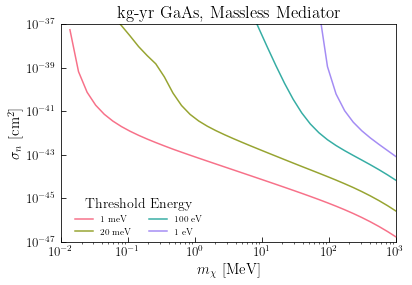

In [11]:
import seaborn as sns

points = 40

mdm = np.logspace(4, 9, points)

reaches1 = np.zeros(points)
reaches2 = np.zeros(points)
reaches3 = np.zeros(points)
reaches4 = np.zeros(points)

import time

for i, mass in enumerate(mdm):
    gaas.update_params(mX = mass, mMed = 0) # update the DM mass
    if (i % 5) == 0:
        start = time.time()
    reaches1[i] = gaas.sigma_multiphonons(1e-3)
    reaches2[i] = gaas.sigma_multiphonons(20e-3)
    reaches3[i] = gaas.sigma_multiphonons(1e-1)
    reaches4[i] = gaas.sigma_multiphonons(1)

    if (i % 5) == 4:
        end = time.time()
        print(f'Points {i - 4} to {i} took {end - start} seconds to calculate')
        # Just to check that everything is still working
        
colors = sns.color_palette("husl", 4)

fig, ax = plt.subplots()


ax.plot(mdm/1e6, reaches1, label='$1$ meV', color=colors[0])
ax.plot(mdm/1e6, reaches2, label='$20$ meV', color=colors[1])
ax.plot(mdm/1e6, reaches3, label='$100$ eV', color=colors[2])
ax.plot(mdm/1e6, reaches4, label='$1$ eV', color=colors[3])


ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('$m_\chi \ [\mathrm{MeV}]$',fontsize=15)
ax.set_ylabel('$\sigma_n \ [\mathrm{cm}^2]$',fontsize=15)

ax.tick_params(axis="both",which="major",labelsize=13,direction="in",pad=5)

ax.set_title(r'kg-yr GaAs, Massless Mediator')

ax.set_xlim([1e-2,1e3])
ax.set_ylim([1e-47,1e-37])

xtick_major = [pow(10.,n) for n in range(-2,4,1)]
ytick_major = [pow(10.,n) for n in range(-47,-36,2)]
ax.set_yticks(ytick_major)
ax.set_xticks(xtick_major)

ax.legend(loc=(0.03,0.01),fontsize=9,frameon=False,ncol=2,title='Threshold Energy')

plt.savefig(plotdir+"gaas_massless_multiphonon.pdf",bbox_inches='tight')


If starting with a new density of states, one must run the 'create_Fn_omega()' function. This defaults to creating the Fn functions corresponding to the density of states (or list of partial density of states) loaded in in the instantiation of the class. This can take an hour or more.

# Differential Rate $\frac{dR}{d\omega}$

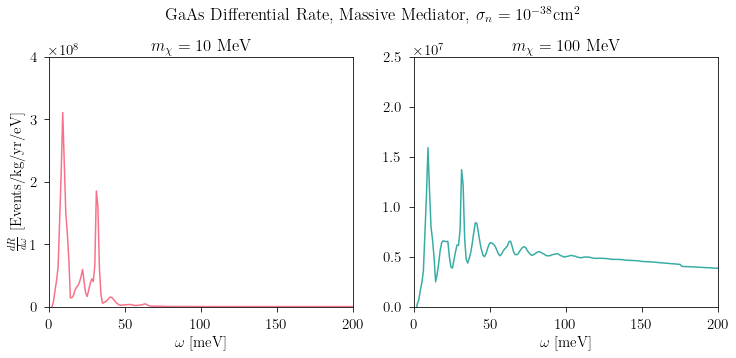

In [6]:
import seaborn as sns

omegarange = np.linspace(1e-4, 200e-3, 200)

gaas.update_params(mX = 1e7, mMed = 1e9) # update the DM mass

dr_domega1 = [gaas._dR_domega_multiphonons_no_single(omega) for omega in omegarange]

gaas.update_params(mX = 1e8, mMed = 1e9) # update the DM mass

dr_domega2 = [gaas._dR_domega_multiphonons_no_single(omega) for omega in omegarange]

colors = sns.color_palette("husl", 2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.6))

ax1.plot(omegarange*1e3, dr_domega1, color=colors[0])
ax2.plot(omegarange*1e3, dr_domega2, color=colors[1])


ax1.set_xlabel(r'$\omega \ [\mathrm{meV}]$',fontsize=15)
ax2.set_xlabel(r'$\omega \ [\mathrm{meV}]$',fontsize=15)
ax1.set_ylabel(r'$\frac{dR}{d\omega} \ [\mathrm{Events}/\mathrm{kg}/\mathrm{yr}/\mathrm{eV}]$',fontsize=15)


ax1.set_title(r'$m_\chi = 10$ MeV')
ax2.set_title(r'$m_\chi = 100$ MeV')

ax1.set_xlim([0,200])
ax2.set_xlim([0,200])

ax1.set_ylim([0,4e8])
ax2.set_ylim([0,2.5e7])


xtick_major = [50*n for n in range(5)]
ytick_major = [1e8*n for n in range(5)]
ax1.set_yticks(ytick_major)

ax1.set_xticks(xtick_major)
ax2.set_xticks(xtick_major)

ytick_major = [0.5e7*n for n in range(6)]
ax2.set_yticks(ytick_major)

plt.suptitle(r'GaAs Differential Rate, Massive Mediator, $\sigma_n = 10^{-38} \mathrm{cm}^2$', y=1.03)

plt.savefig(plotdir+"gaas_massive_rates.pdf",bbox_inches='tight')

# Custom Momentum-dependent coupling (Dark Photon)

Here we calculate the cross-section for a rate of 3 events/kg/yr for a dark photon, using custom atomic couplings. In order to do this, the form factor must be loaded in at the instantiation of the class via 'fd_filename' (multiple filenames if multiple atoms) and the flag 'dark_photon' must be set to 'True' in function calls. Note that the default coupling without a custom coupling is the mass number.

Our effective charge here is valid for processes dominated by large momenta (massive mediator or $\geq2$-phonon calculations.

 .... Loading files for Si
Warning! Epsilon grid in electron regime does not exist.
Warning! eps for phonon frequencies not loaded. Need to set phonon_filename 
Loaded Si_DoS.dat for density of states
Loaded Fn(omega) functions corresponding to density of states in:  Si_DoS.dat
Loaded Si_atomic_Zion_kdependent.dat for dark photon couplings
Points 0 to 4 took 4.920024871826172 seconds to calculate
Points 5 to 9 took 6.028233289718628 seconds to calculate
Points 10 to 14 took 8.659124851226807 seconds to calculate
Points 15 to 19 took 7.303524971008301 seconds to calculate


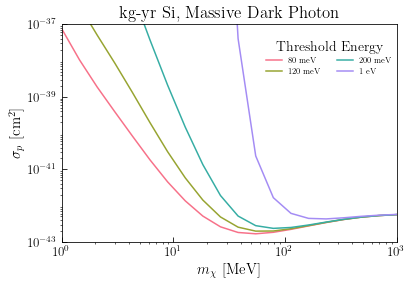

In [7]:
import seaborn as sns

# Loads dark photon form factor 
si = darkelf(target='Si',dos_filename="Si_DoS.dat",
             fd_filename='Si_atomic_Zion_kdependent.dat')

points = 20

mdm = np.logspace(6, 9, points)

(reaches1, reaches2, reaches3, reaches4) = (np.zeros(points),np.zeros(points),np.zeros(points),np.zeros(points))

import time

for i, mass in enumerate(mdm):
    si.update_params(mX = mass, mMed = 1e10) # update the DM mass
    if (i % 5) == 0:
        start = time.time()
    reaches1[i] = si.sigma_multiphonons(80e-3, dark_photon=True)
    reaches2[i] = si.sigma_multiphonons(120e-3, dark_photon=True)
    reaches3[i] = si.sigma_multiphonons(200e-3, dark_photon=True)
    reaches4[i] = si.sigma_multiphonons(1000e-3, dark_photon=True)


    if (i % 5) == 4:
        end = time.time()
        print(f'Points {i - 4} to {i} took {end - start} seconds to calculate')
        # Just to check that everything is still working
        
colors = sns.color_palette("husl", 4)

fig, ax = plt.subplots()

ax.plot(mdm/1e6, reaches1, label='$80$ meV', color=colors[0])
ax.plot(mdm/1e6, reaches2, label='$120$ meV', color=colors[1])
ax.plot(mdm/1e6, reaches3, label='$200$ meV', color=colors[2])
ax.plot(mdm/1e6, reaches4, label='$1$ eV', color=colors[3])

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim([1e0,1e3])
ax.set_ylim([1e-43,1e-37])

ax.set_xlabel('$m_\chi \ [\mathrm{MeV}]$',fontsize=15)
ax.set_ylabel('$\sigma_p \ [\mathrm{cm}^2]$',fontsize=15)

ax.tick_params(axis="both",which="major",labelsize=13,direction="in",pad=5)

xtick_major = [pow(10.,n) for n in range(0,4,1)]
ytick_major = [pow(10.,n) for n in range(-43,-36,2)]
ax.set_yticks(ytick_major)
ax.set_xticks(xtick_major)

ax.set_title(r'kg-yr Si, Massive Dark Photon')

ax.legend(loc=(0.60,0.75),fontsize=8,frameon=False,ncol=2,title="Threshold Energy",)

plt.savefig(plotdir+"si_massive_dark_photon.pdf",bbox_inches='tight')


In [9]:
gaas.create_Fn_omega(npoints=750)

Finished point #50 out of 250 for 2 phonons
Finished point #100 out of 250 for 2 phonons
Finished point #150 out of 250 for 2 phonons
Finished point #200 out of 250 for 2 phonons
Finished point #250 out of 250 for 2 phonons
30.076100826263428 seconds for 2 phonons
Finished point #50 out of 250 for 3 phonons
Finished point #100 out of 250 for 3 phonons
Finished point #150 out of 250 for 3 phonons
Finished point #200 out of 250 for 3 phonons
Finished point #250 out of 250 for 3 phonons
59.788800954818726 seconds for 3 phonons
Finished point #50 out of 250 for 4 phonons
Finished point #100 out of 250 for 4 phonons
Finished point #150 out of 250 for 4 phonons
Finished point #200 out of 250 for 4 phonons
Finished point #250 out of 250 for 4 phonons
92.4654221534729 seconds for 4 phonons
Finished point #50 out of 250 for 5 phonons
Finished point #100 out of 250 for 5 phonons
Finished point #150 out of 250 for 5 phonons
Finished point #200 out of 250 for 5 phonons
Finished point #250 out of 2

In [10]:
gaas.create_Fn_omega(npoints=750)

Finished point #50 out of 750 for 2 phonons
Finished point #100 out of 750 for 2 phonons
Finished point #150 out of 750 for 2 phonons
Finished point #200 out of 750 for 2 phonons
Finished point #250 out of 750 for 2 phonons
Finished point #300 out of 750 for 2 phonons
Finished point #350 out of 750 for 2 phonons
Finished point #400 out of 750 for 2 phonons
Finished point #450 out of 750 for 2 phonons
Finished point #500 out of 750 for 2 phonons
Finished point #550 out of 750 for 2 phonons
Finished point #600 out of 750 for 2 phonons
Finished point #650 out of 750 for 2 phonons
Finished point #700 out of 750 for 2 phonons
Finished point #750 out of 750 for 2 phonons
91.03369998931885 seconds for 2 phonons
Finished point #50 out of 750 for 3 phonons
Finished point #100 out of 750 for 3 phonons
Finished point #150 out of 750 for 3 phonons
Finished point #200 out of 750 for 3 phonons
Finished point #250 out of 750 for 3 phonons
Finished point #300 out of 750 for 3 phonons
Finished point #3

Finished point #450 out of 750 for 4 phonons
Finished point #500 out of 750 for 4 phonons
Finished point #550 out of 750 for 4 phonons
Finished point #600 out of 750 for 4 phonons
Finished point #650 out of 750 for 4 phonons
Finished point #700 out of 750 for 4 phonons
Finished point #750 out of 750 for 4 phonons
394.90396189689636 seconds for 4 phonons
Finished point #50 out of 750 for 5 phonons
Finished point #100 out of 750 for 5 phonons
Finished point #150 out of 750 for 5 phonons
Finished point #200 out of 750 for 5 phonons
Finished point #250 out of 750 for 5 phonons
Finished point #300 out of 750 for 5 phonons
Finished point #350 out of 750 for 5 phonons
Finished point #400 out of 750 for 5 phonons
Finished point #450 out of 750 for 5 phonons
Finished point #500 out of 750 for 5 phonons
Finished point #550 out of 750 for 5 phonons
Finished point #600 out of 750 for 5 phonons
Finished point #650 out of 750 for 5 phonons
Finished point #700 out of 750 for 5 phonons
Finished point 